In [1]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import shap
import pandas as pd
from tqdm import tqdm
import random
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from sklearn.metrics import *

import os
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

def set_seed(seed):
    # Set the random seed for PyTorch on CPU and GPU
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed for Python's built-in random module
    random.seed(seed)

In [2]:
# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()
        self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)
        self.bn2 = nn.BatchNorm1d(num_features=hidden_size2)

    def forward(self, x):
        # breakpoint()
        x = self.fc1(x)
        x = self.bn1(self.relu1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(self.relu2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x
    
    # MLP 모델 정의
class MLP_1layer(nn.Module):
    def __init__(self, input_size, hidden_size1, output_size):
        super(MLP_1layer, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size1, output_size)
        self.sigmoid = nn.Sigmoid()
        self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)

    def forward(self, x):
        # breakpoint()
        x = self.fc1(x)
        x = self.bn1(self.relu1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split

class TabularDataset(Dataset) :
    def __init__(self, X , y) :
        self.X = X
        self.y = y
    def __len__(self) :
        return len(self.X)
    def __getitem__(self,idx) :
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()
        return [self.X.iloc[idx].values, self.y.iloc[idx]]      # X가 Dataframe일 때
        # return [self.X[idx], self.y[idx]]       # X가 array일 때

In [4]:
# test에 나머지 control sample 추가해서 idx 만 반환
def divide_testset(unbalanced_data, ratio, seed):
    # train에서 ckd, control index 확인
    total_idx = unbalanced_data.index
    ckd_idx = unbalanced_data[unbalanced_data['onset_tight'] == 1].index        # 실제 ckd
    control_idx = unbalanced_data[unbalanced_data['onset_tight'] == 0].index    # 실제 control
    # print(control_idx, ckd_idx)

    # ckd 갯수와 동일하게 control idx sampling
    rng = np.random.default_rng(seed)   # always same test set
    sampled_ckd_idx = pd.Index(rng.choice(ckd_idx, size=int(len(ckd_idx)*ratio), replace=False))
    sampled_control_idx = pd.Index(rng.choice(control_idx, size=len(sampled_ckd_idx), replace=False)) # test_ckd 갯수와 동일하게 sampling
    
    test_idx = sampled_ckd_idx.append(sampled_control_idx)
    train_idx = total_idx.difference(test_idx)

    # return 실제 ckd, 실제 ckd 갯수와 동일한 갯수의 subject, control_idx - ckd_idx
    return unbalanced_data.loc[train_idx], unbalanced_data.loc[test_idx]


# test에 나머지 control sample 추가해서 idx 만 반환
def _under_sampling_idx(unbalanced_data, seed):
    # train에서 ckd, control index 확인
    ckd_idx = unbalanced_data[unbalanced_data['onset_tight'] == 1].index        # 실제 ckd
    control_idx = unbalanced_data[unbalanced_data['onset_tight'] == 0].index    # 실제 control

    # ckd 갯수와 동일하게 control idx sampling
    """
    Control을 CKD와 어떤 비율로 뽑을지.
    """
    rng = np.random.default_rng(seed = seed) 
    sampled_control_idx = pd.Index(rng.choice(control_idx, size= len(ckd_idx), replace=False)) # ckd 갯수와 동일하게 sampling
    not_sampled_control_idx = control_idx.difference(sampled_control_idx)

    assert set(sampled_control_idx).issubset(set(control_idx))
    
    balanced_idx = sampled_control_idx.append(ckd_idx)

    # return 실제 ckd, 실제 ckd 갯수와 동일한 갯수의 subject, control_idx - ckd_idx
    return ckd_idx, sampled_control_idx, not_sampled_control_idx, balanced_idx

def undersampling(unbalanced_data, seed):
    a, b, c, d = _under_sampling_idx(unbalanced_data, seed)
    under_sampled_data = unbalanced_data.loc[d]
    X_undersampled = under_sampled_data.drop(['RID', 'onset_tight'], axis=1)
    y_undersampled = under_sampled_data['onset_tight']
    return X_undersampled, y_undersampled

def oversampling(unbalanced_dataframe, seed):
    smote = SMOTE(random_state=seed)
    temp = unbalanced_dataframe.drop(['RID'], axis=1)
    X_train, y_train = smote.fit_resample(temp, temp['onset_tight'])

    # X_train에는 RID, onset_3 없음.
    return X_train.drop(['onset_tight'], axis=1), y_train

def normalizing(X_train, X_valid, X_test):
    # pd.Dataframe -> pd.Dataframe
    columns = X_train.columns
    
    wei_train_scaler = StandardScaler()
    # wei_train_scaler =MinMaxScaler()
    X_train_scaled = wei_train_scaler.fit_transform(X_train)
    X_valid_scaled = wei_train_scaler.transform(X_valid)
    X_test_scaled = wei_train_scaler.transform(X_test)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=columns, index=X_train.index)
    X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=columns, index=X_valid.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=columns, index=X_test.index)
    
    return X_train_scaled, X_valid_scaled, X_test_scaled

In [5]:
# data = pd.read_csv("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_food_mean_only.csv")
# data = pd.read_csv("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_food_adjusted_mean_only.csv")

# # Using partial food feature
# # 1, 2, 4, 16, 5, 10, 13, 16
# data = data[data.columns[[0, 1, 2, 3, 5, 5, 11, 14, 17]]]

In [ ]:
data['']

In [139]:
seed = 300
set_seed(seed)


## For Cross validation
X_train, y_train = undersampling(X_train, seed=seed)

y_test = X_test['onset_tight']
X_test = X_test.drop(['RID', 'onset_tight'], axis=1)

X_train_scaled, _, X_test_scaled = normalizing(X_train, X_test, X_test)
X_train_scaled, y_train, X_test_scaled, y_test = X_train_scaled.astype('float32'), y_train.astype('float32'), X_test_scaled.astype('float32'), y_test.astype('float32')

print(X_train_scaled.shape)

# ## For No- Cross validation
# X_train, X_test = divide_testset(data, ratio=0.1, seed=seed)
# X_train, y_train = undersampling(X_train, seed=seed)

# y_test = X_test['onset_tight']
# X_test = X_test.drop(['RID', 'onset_tight'], axis=1)

# X_train_scaled, _, X_test_scaled = normalizing(X_train, X_test, X_test)
# X_train_scaled, y_train, X_test_scaled, y_test = X_train_scaled.astype('float32'), y_train.astype('float32'), X_test_scaled.astype('float32'), y_test.astype('float32')

# print(X_train_scaled.shape)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

##### Food feature t-sne

In [ ]:
food_mean = pd.read_csv("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_food_mean_only.csv")
food_adjusted_mean = pd.read_csv("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_food_adjusted_mean_only.csv")

In [ ]:
food_adjusted_mean_train, food_adjusted_mean_test = divide_testset(food_adjusted_mean, ratio=0.1, seed=seed)
X_food_adjusted_mean_train, y_food_adjusted_mean_train = undersampling(food_adjusted_mean_train, seed=seed)

y_food_adjusted_mean_test = food_adjusted_mean_test['onset_tight']
X_food_adjusted_mean_test = food_adjusted_mean_test.drop(['onset_tight', 'RID'], axis=1)

In [ ]:
X_food_mean, y_food_mean = undersampling(food_mean, seed=seed)
X_food_adjusted_mean, y_food_adjusted_mean = undersampling(food_adjusted_mean, seed=seed)

X_food_mean_scaled, _, _ = normalizing(X_food_mean, X_food_mean, X_food_mean)
X_food_adjusted_mean_scaled, _, _ = normalizing(X_food_adjusted_mean, X_food_adjusted_mean, X_food_adjusted_mean)

In [ ]:
def tsne_visualization(data, y_label, food_type, seed):
    # t-SNE 모델 생성 및 2차원으로 변환
    tsne = TSNE(n_components=2, random_state=seed)
    X_embedded = tsne.fit_transform(data)

    # 결과를 DataFrame으로 변환하여 label 정보 추가
    tsne_df = pd.DataFrame(X_embedded, columns=['TSNE1', 'TSNE2'])
    tsne_df['label'] = y_label.values

    # Control과 CKD의 색상을 구분해서 시각화
    plt.figure(figsize=(10, 8))
    plt.scatter(X_embedded[y_label == 0, 0], X_embedded[y_label == 0, 1], 
                color='blue', label='Control', alpha=0.6)
    plt.scatter(X_embedded[y_label == 1, 0], X_embedded[y_label == 1, 1], 
                color='red', label='CKD', alpha=0.6)

    # 그래프 제목 및 축 레이블 설정
    plt.title(f"t-SNE of Food {food_type} (Control vs CKD)")
    plt.xlabel("TSNE Component 1")
    plt.ylabel("TSNE Component 2")
    plt.legend(title="Label")
    plt.show()

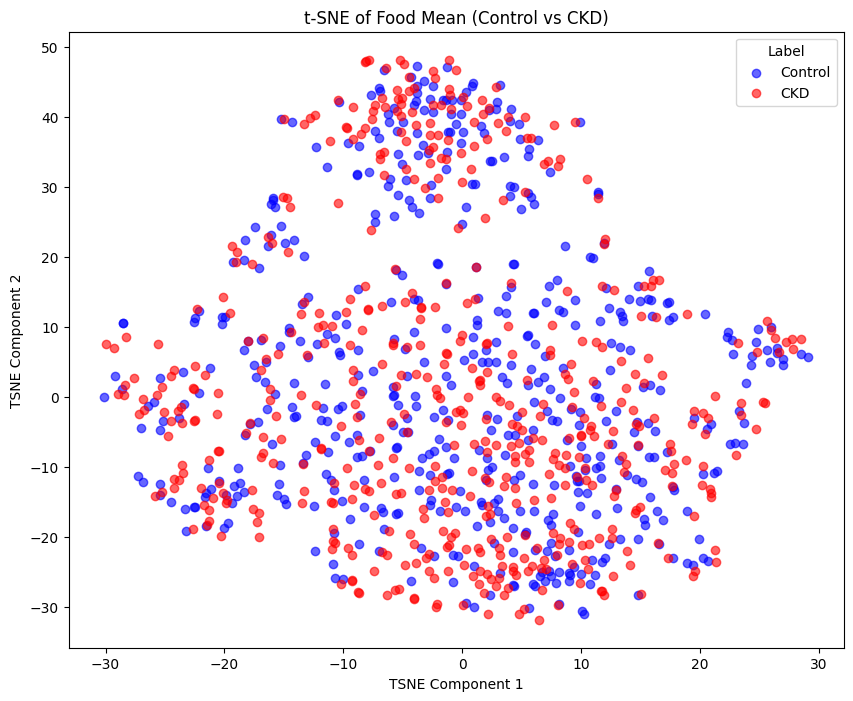

In [ ]:
"""Food mean tsne"""

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne_visualization(X_food_mean_scaled, y_food_mean, "Mean", seed)

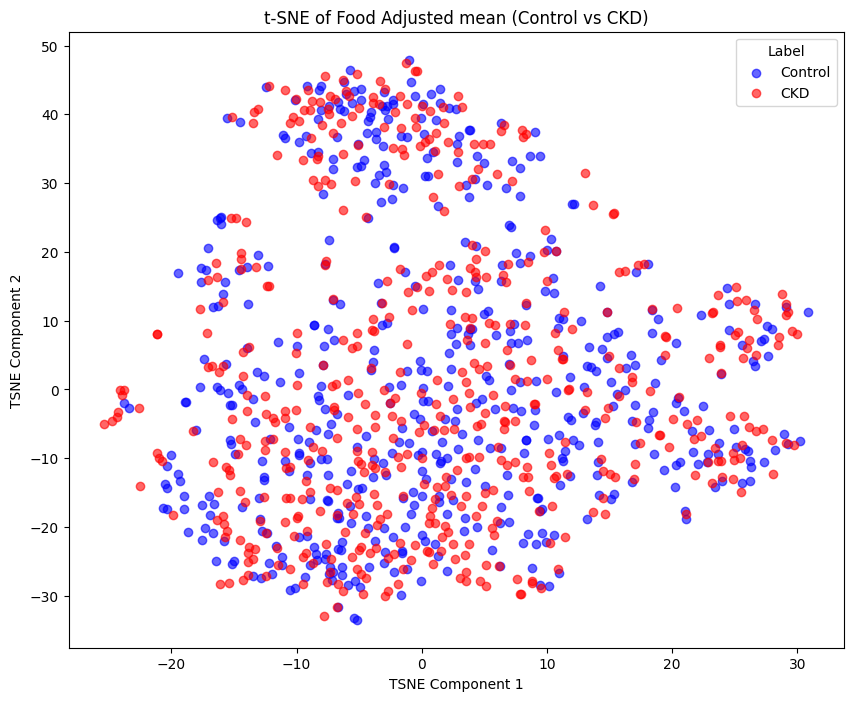

In [ ]:
"""Food adjusted mean tsne"""

tsne_visualization(X_food_adjusted_mean_scaled, y_food_mean, "Adjusted mean", seed)

##### 

In [ ]:
trainset = TabularDataset(X_train_scaled , y_train)
testset = TabularDataset(X_test_scaled , y_test)

trainloader = DataLoader(trainset, batch_size=1000, shuffle=True)
testloader = DataLoader(testset, batch_size=1000, shuffle=False)

In [140]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [141]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, roc_auc_score

def metric(y_test, y_pred):  # label, pred
    y_test = y_test.cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()
    y_pred = y_pred.flatten()
    y_pred = np.where(y_pred > 0.5, 1, 0)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate recall, precision, accuracy
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate AUC of ROC
    auc = roc_auc_score(y_test, y_pred)
    
    # Return all metrics
    return recall, precision, accuracy, auc, cm

In [142]:
def train(model, optimizer, criterion, epoch, train_loader, l1_lambda=0.1):
    t = time.time()
    model.train()
    for train_input, train_label in train_loader:
        train_input = train_input.cuda(device)
        train_label = train_label.cuda(device)
        optimizer.zero_grad()
        
        # breakpoint()
        output = model(train_input)
        loss_train = criterion(output.squeeze(), train_label)
            
        if l1_lambda > 0:
            l1_norm = sum(p.abs().sum() for p in model.parameters())    # l1 norm
            loss_train += l1_lambda * l1_norm
    
        recall_train, precision_train, acc_train, auc_train, cm_train = metric(train_label, output)
        loss_train.backward()
        optimizer.step()
    
    # print("epoch : {:04d}, loss_train: {:.4f}, recall_train: {:.4f}, precision_train: {:.4f}, acc_train: {:.4f}, auc_train: {:.4f}, time: {:.4f}s".format(
    #     epoch+1, loss_train.item(), recall_train.item(), precision_train.item(), acc_train.item(), auc_train.item(), time.time() - t
    # ))
    
    # print("Train results ==> epoch : {:04d}, loss_train: {:.4f}, acc_train: {:.4f}, time: {:.4f}s".format(
    #     epoch+1, loss_train.item(), acc_train.item(), time.time() - t
    # ))

In [143]:
def test_CV(model, criterion, X_test, y_test):
    model.eval()
    with torch.no_grad():
        # 데이터를 GPU로 이동
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)
        
        # 모델 예측
        output_test = model(X_test_tensor)
        
        loss_test = criterion(output_test.squeeze(), y_test_tensor)
        
        # # 예측 결과 평가 (예측값을 0.5로 이진 분류)
        # total_label = y_test_tensor.cpu().detach().numpy()
        # total_pred = output_test.cpu().detach().numpy()
        
        # 정확도, 재현율, 정밀도, AUC 등의 메트릭 계산
        recall_test, precision_test, acc_test, auc_test, cm_test = metric(y_test_tensor, output_test)
        
        # 결과 로그 출력
        # logger.info("Test set results")
        print("Test set results ==> loss= {:.4f}, recall= {:.4f}, precision= {:.4f}, accuracy= {:.4f}, AUC= {:.4f}".format(
            loss_test.item(), recall_test, precision_test, acc_test, auc_test))
        output_test = output_test.cpu().detach()
        
        return output_test, loss_test.item(), recall_test, precision_test, acc_test, auc_test, cm_test

In [171]:
from sklearn.model_selection import KFold

def cross_validate(model_class, X_train_scaled, y_train, hidden1, hidden2):
    # KFold 객체 생성 (n_splits = 폴드 수)
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)

    # 데이터셋에서 입력과 라벨을 분리
    X = X_train_scaled
    y = y_train

    fold_losses, fold_recalls, fold_precisions, fold_accuracies, fold_aucs = [], [], [], [], []

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        print(f'Fold {fold+1}')

        # 학습 데이터와 검증 데이터 분리
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        # print(f"Train : {X_train.shape}, Test : {X_val.shape}")
        # print(f"Train : {y_train.shape}, Test : {y_val.shape}")
        
        # X_scaled = torch.tensor(X_scaled.values)
        # y = torch.tensor(y.values)
        
        train_loader = DataLoader(TensorDataset(torch.tensor(X_train.values), torch.tensor(y_train.values)), batch_size=1000, shuffle=True)
        valid_loader = DataLoader(TensorDataset(torch.tensor(X_val.values), torch.tensor(y_val.values)), batch_size=1000, shuffle=False)

        # 모델 초기화
        if model_class == MLP:
            model = MLP(input_size=X_train.shape[1], hidden_size1=hidden1, hidden_size2=hidden2, output_size=1).to(device)
        elif model_class == MLP_1layer:
            model = MLP_1layer(input_size=X_train.shape[1], hidden_size1=hidden1, output_size=1).to(device)
        # print(model)
        
        optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.)
        criterion = nn.BCELoss()
        
        # 학습
        for epoch in range(200):
            train(model, optimizer, criterion, epoch, train_loader, l1_lambda=0.)

        # 검증
        output_val, loss_val, recall_val, precision_val, acc_val, roc_val, cm_val = test_CV(model, criterion, X_val, y_val)
        fold_losses.append(loss_val)
        fold_recalls.append(recall_val)
        fold_precisions.append(precision_val)
        fold_accuracies.append(acc_val)
        fold_aucs.append(roc_val)
        
        # print(f"Fold {fold+1} Validation results")
        # print(f"Loss, Recall, Precision, ACC, ROC:")
        # print(f"{loss_val:.4f}, {recall_val:.4f}, {precision_val:.4f}, {acc_val:.4f}, {roc_val:.4f}")
        

    # 전체 폴드의 평균 정확도 출력
    mean_fold_loss, std_fold_loss = np.mean(fold_losses), np.std(fold_losses)
    mean_fold_recall, std_fold_recall = np.mean(fold_recalls), np.std(fold_recalls)
    mean_fold_pricision, std_fold_precision = np.mean(fold_precisions), np.std(fold_precisions)
    mean_fold_accuracy, std_fold_accuracy = np.mean(fold_accuracies), np.std(fold_accuracies)
    mean_fold_auc, std_fold_auc = np.mean(fold_aucs), np.std(fold_aucs)
    print('!!! Cross-Validation Mean Accuracy !!!')
    print(f'loss  /  recall  /  precision  /  ACC  /  ROC  ')
    print(f'MEAN :: {mean_fold_loss:.4f}, {mean_fold_recall:.4f}, {mean_fold_pricision:.4f}, {mean_fold_accuracy:.4f}, {mean_fold_auc:.4f}')
    print(f'STD :: {std_fold_loss:.4f}, {std_fold_recall:.4f}, {std_fold_precision:.4f}, {std_fold_accuracy:.4f}, {std_fold_auc:.4f}')

In [172]:
# 42, 59, 63, 79, 101
seed = 42
set_seed(seed)

data = pd.read_csv("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_food_mean_only.csv")
# data = pd.read_csv("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_food_adjusted_mean_only.csv")

## For Cross validation
X, y = undersampling(data, seed=seed)
X_scaled, _, _ = normalizing(X, X, X)
print(X_scaled.shape)
X_scaled, y = X_scaled.astype('float32'), y.astype('float32')

# X_scaled_shap = X_scaled[X_scaled.columns[[0, 3, 1, 13, 11, 14, 5, 4, 6, 18]]]        # for food mean
# X_scaled_shap = X_scaled[X_scaled.columns[[1, 0, 3, 11, 19, 4, 20, 6, 16, 15]]]          # for food adjusted mean

# print(X_scaled_shap.shape)
# X_food_mean.columns

(1050, 21)


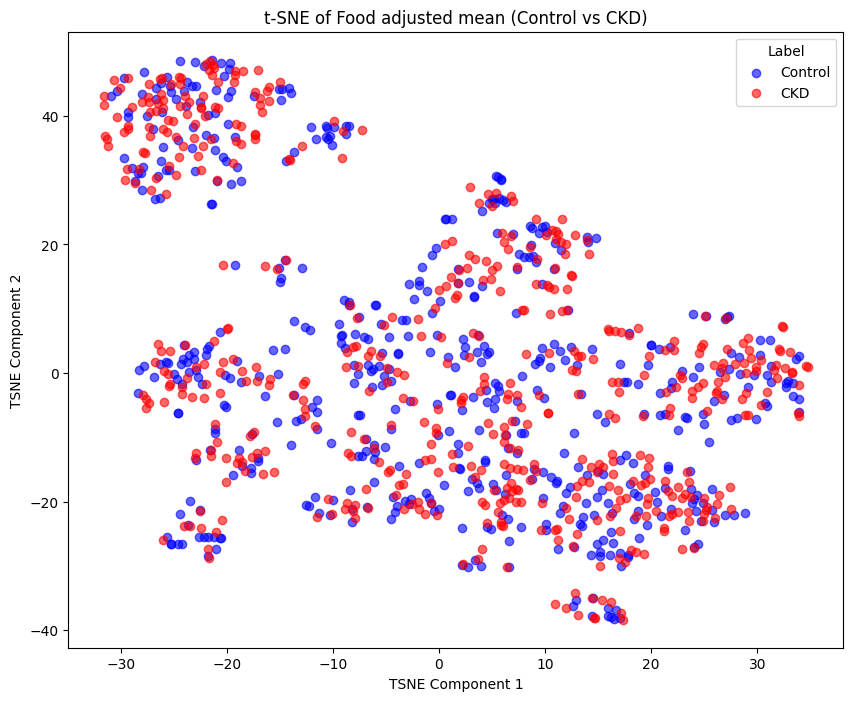

In [154]:
# tsne_visualization(X_scaled_shap, y_food_mean, "mean", seed)
# tsne_visualization(X_scaled_shap, y_food_mean, "adjusted mean", seed)

In [133]:
hiddens = [
    # (64, 64), (64, 32), (64, 16), (64, 8), (64, 4),
    #         (32, 32), (32, 16), (32, 8), (32, 4),
            (16, 16), (16, 8), (16, 4), (8, 8), (8, 4), (4, 4)]

for hidden1, hidden2 in hiddens:
    
    print(f"===== hidden1 : {hidden1}, hidden2 : {hidden2} =====")
    
    # cross_validate(MLP, X_scaled, y, hidden1, hidden2)
    cross_validate(MLP, X_scaled_shap, y, hidden1, hidden2)
    print("=" * 30)

===== hidden1 : 16, hidden2 : 16 =====
Fold 1
Test set results ==> loss= 0.6965, recall= 0.5952, precision= 0.4386, accuracy= 0.5333, AUC= 0.5437
Fold 2
Test set results ==> loss= 0.6364, recall= 0.7347, precision= 0.5625, accuracy= 0.6095, AUC= 0.6173
Fold 3
Test set results ==> loss= 0.6671, recall= 0.6964, precision= 0.5909, accuracy= 0.5810, AUC= 0.5727
Fold 4
Test set results ==> loss= 0.6725, recall= 0.6167, precision= 0.6852, accuracy= 0.6190, AUC= 0.6194
Fold 5
Test set results ==> loss= 0.6980, recall= 0.4655, precision= 0.6136, accuracy= 0.5429, AUC= 0.5519
Fold 6
Test set results ==> loss= 0.6581, recall= 0.6667, precision= 0.5667, accuracy= 0.5905, AUC= 0.5926
Fold 7
Test set results ==> loss= 0.6622, recall= 0.7292, precision= 0.5147, accuracy= 0.5619, AUC= 0.5751
Fold 8
Test set results ==> loss= 0.7319, recall= 0.6316, precision= 0.6316, accuracy= 0.6000, AUC= 0.5970
Fold 9
Test set results ==> loss= 0.7194, recall= 0.6596, precision= 0.4769, accuracy= 0.5238, AUC= 0.536

In [160]:
hiddens = [
            (64, 64), (32, 32), 
        #    (16, 16), (8, 8), (4, 4)
           ]

for hidden1, hidden2 in hiddens:
    
    print(f"===== hidden1 : {hidden1}, hidden2 : {hidden2} =====")
    
    cross_validate(MLP_1layer, X_scaled, y, hidden1, hidden2)
    # cross_validate(MLP_1layer, X_scaled_shap, y, hidden1, hidden2)
    print("=" * 30)

===== hidden1 : 64, hidden2 : 64 =====
Fold 1
Test set results ==> loss= 0.9073, recall= 0.5918, precision= 0.5472, accuracy= 0.5810, AUC= 0.5816
Fold 2
Test set results ==> loss= 1.0627, recall= 0.4808, precision= 0.5814, accuracy= 0.5714, AUC= 0.5706
Fold 3
Test set results ==> loss= 1.9795, recall= 0.5510, precision= 0.4821, accuracy= 0.5143, AUC= 0.5166
Fold 4
Test set results ==> loss= 0.8263, recall= 0.4510, precision= 0.5897, accuracy= 0.5810, AUC= 0.5773
Fold 5
Test set results ==> loss= 0.6929, recall= 0.5000, precision= 0.5200, accuracy= 0.5238, AUC= 0.5236
Fold 6
Test set results ==> loss= 1.0378, recall= 0.6047, precision= 0.5200, accuracy= 0.6095, AUC= 0.6088
Fold 7
Test set results ==> loss= 0.9127, recall= 0.5893, precision= 0.5690, accuracy= 0.5429, AUC= 0.5395
Fold 8
Test set results ==> loss= 0.8927, recall= 0.3607, precision= 0.5946, accuracy= 0.4857, AUC= 0.5099
Fold 9
Test set results ==> loss= 0.7865, recall= 0.5484, precision= 0.6800, accuracy= 0.5810, AUC= 0.588

In [21]:
# hiddens = [(64, 64), (64, 32), (64, 16), (64, 8), (64, 4),
#             (32, 32), (32, 16), (32, 8), (32, 4),
#             (16, 16), (16, 8), (16, 4), (8, 8), (8, 4), (4, 4)]

# for hidden1, hidden2 in hiddens:
#     print(f"===== hidden1 : {hidden1}, hidden2 : {hidden2} =====")
#     model = MLP(input_size=X_train.shape[1], hidden_size1=hidden1, hidden_size2=hidden2, output_size=1).to(device)
#     # model = MLP_1layer(input_size=X_train.shape[1], hidden_size1=hidden1, output_size=1).to(device)
#     print(model)
#     optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0)
#     criterion = nn.BCELoss()

#     # Train model
#     t_total = time.time()
#     for epoch in range(200):
        train(model, optimizer, criterion, epoch, trainloader, l1_lambda=0)
#     print("=====Optimization Finished!=====")
#     print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

#     outputs, _, _, _, _, _, cm_test = test_CV(model, criterion, X_test_scaled, y_test)
#     print()
#     print()
#     print("=" * 30)

# # hiddens = [(16, 4), (8, 8), (8, 4), (4, 4)]
# # hiddens = [(8, 8), (4, 4)]

# # hiddens = [(64, 64), (32, 3), (16, 3), (8, 3), (4, 3)]

===== hidden1 : 64, hidden2 : 64 =====
MLP(
  (fc1): Linear(in_features=21, out_features=64, bias=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
epoch : 0001, loss_train: 0.7544, recall_train: 0.4820, precision_train: 0.4946, acc_train: 0.4947, auc_train: 0.4947, time: 0.0459s
epoch : 0002, loss_train: 0.7694, recall_train: 0.5581, precision_train: 0.5087, acc_train: 0.5095, auc_train: 0.5095, time: 0.0892s
epoch : 0003, loss_train: 0.9786, recall_train: 0.4968, precision_train: 0.5281, acc_train: 0.5264, auc_train: 0.5264, time: 0.0766s
epo

In [20]:
# # hiddens = [(16, 4)]

# hiddens = [(32, 4), (16, 8), (8, 4), (4, 4)]

# for hidden1, hidden2 in hiddens:
#     print(f"===== hidden1 : {hidden1}, hidden2 : {hidden2} =====")
#     # model = MLP(input_size=X_train.shape[1], hidden_size1=hidden1, hidden_size2=hidden2, output_size=1).to(device)
#     model = MLP_1layer(input_size=X_train.shape[1], hidden_size1=hidden1, output_size=1).to(device)
#     print(model)
#     optimizer = optim.Adam(model.parameters(), lr=0.02, weight_decay=0)
#     criterion = nn.BCELoss()

#     # Train model
#     t_total = time.time()
#     for epoch in range(200):
#         train(model, optimizer, criterion, epoch, trainloader, l1_lambda=0)
#     print("=====Optimization Finished!=====")
#     print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

#     outputs, _, _, _, _, _, cm_test = test_CV(model, criterion, X_test_scaled, y_test)
#     print()
#     print()
#     print("=" * 30)

===== hidden1 : 32, hidden2 : 4 =====
MLP_1layer(
  (fc1): Linear(in_features=21, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
epoch : 0001, loss_train: 0.8077, recall_train: 0.5983, precision_train: 0.5054, acc_train: 0.5063, auc_train: 0.5063, time: 0.0673s
epoch : 0002, loss_train: 0.7248, recall_train: 0.5941, precision_train: 0.5252, acc_train: 0.5285, auc_train: 0.5285, time: 0.0909s
epoch : 0003, loss_train: 0.7136, recall_train: 0.5222, precision_train: 0.5031, acc_train: 0.5032, auc_train: 0.5032, time: 0.0499s
epoch : 0004, loss_train: 0.6938, recall_train: 0.5370, precision_train: 0.5314, acc_train: 0.5317, auc_train: 0.5317, time: 0.0453s
epoch : 0005, loss_train: 0.6870, recall_train: 0.5539, precision_train: 0.5493, acc_train: 0.5497,

In [ ]:
# model = MLP(input_size=X_train.shape[1], hidden_size1=32, hidden_size2=32, output_size=1).to(device)
# # model = MLP_1layer(input_size=X_train.shape[1], hidden_size1=16, output_size=1).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0)
# criterion = nn.BCELoss()

# # Train model
# t_total = time.time()
# for epoch in range(200):
#     train(model, optimizer, criterion, epoch, trainloader, l1_lambda=0)
# print("=====Optimization Finished!=====")
# print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# outputs, _, _, _, _, _, cm_test = test_CV(model, criterion, X_test_scaled, y_test)

In [ ]:
# cm_test

#### Shap 기준 중요한 food feature 를 뽑아서 학습

##### Food mean

In [232]:
# 42, 59, 63, 79, 101
seed = 101
set_seed(seed)

data = pd.read_csv("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_food_mean_only.csv")
# data = pd.read_csv("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_food_adjusted_mean_only.csv")

## For Cross validation
X, y = undersampling(data, seed=seed)
X_scaled, _, _ = normalizing(X, X, X)
print(X_scaled.shape)
X_scaled, y = X_scaled.astype('float32'), y.astype('float32')

(1050, 21)


In [233]:
# # F_mean : 1 4 2 14 12 15 6 5 7 19  => index : 0, 3, 1, 13, 11, 14, 5, 4, 6, 18
# # F_mean :   => index : 
# X_scaled.columns[[0, 3, 1, 13, 11, 14, 5, 4, 6, 18]]
# # X_scaled.columns[1 4 2 14 12 15 6 5 7 19]

In [234]:
X_scaled_shap = X_scaled[X_scaled.columns[[0, 3, 1, 13, 11, 14, 5, 4, 6, 18]]]
# X_scaled_shap = X_scaled[X_scaled.columns[[1, 0, 3, 11, 19, 4, 20, 6, 16, 15]]]

In [235]:
# tsne_visualization(X_scaled_shap, y_food_mean, "mean", seed)

In [237]:
hiddens = [
    # (64, 64), (64, 32), (64, 16), (64, 8), (64, 4),
    #         (32, 32), (32, 16), (32, 8), (32, 4),
            # (16, 16), (16, 8), (16, 4), (8, 8), (8, 4), (4, 4)
            (64, 16)
            ]

for hidden1, hidden2 in hiddens:
    
    print(f"===== hidden1 : {hidden1}, hidden2 : {hidden2} =====")
    
    cross_validate(MLP, X_scaled, y, hidden1, hidden2)
    
    print("=" * 30)
    cross_validate(MLP, X_scaled_shap, y, hidden1, hidden2)
    
    print("=" * 30)

===== hidden1 : 64, hidden2 : 16 =====
Fold 1


Test set results ==> loss= 0.8672, recall= 0.5000, precision= 0.4314, accuracy= 0.5143, AUC= 0.5123
Fold 2
Test set results ==> loss= 0.9682, recall= 0.4643, precision= 0.5778, accuracy= 0.5333, AUC= 0.5383
Fold 3
Test set results ==> loss= 0.8332, recall= 0.7059, precision= 0.5625, accuracy= 0.5905, AUC= 0.5937
Fold 4
Test set results ==> loss= 0.8981, recall= 0.6481, precision= 0.5738, accuracy= 0.5714, AUC= 0.5692
Fold 5
Test set results ==> loss= 0.8590, recall= 0.6471, precision= 0.5000, accuracy= 0.5143, AUC= 0.5180
Fold 6
Test set results ==> loss= 0.8429, recall= 0.4909, precision= 0.6279, accuracy= 0.5810, AUC= 0.5855
Fold 7
Test set results ==> loss= 0.7640, recall= 0.5000, precision= 0.5870, accuracy= 0.5619, AUC= 0.5637
Fold 8
Test set results ==> loss= 0.9321, recall= 0.4909, precision= 0.5400, accuracy= 0.5143, AUC= 0.5155
Fold 9
Test set results ==> loss= 0.8446, recall= 0.5192, precision= 0.4909, accuracy= 0.4952, AUC= 0.4955
Fold 10
Test set results ==> loss= 1.0092, r

In [43]:
hiddens = [
    # (64, 64), (32, 32), 
    (16, 16), (8, 8), (4, 4)]

for hidden1, hidden2 in hiddens:
    
    print(f"===== hidden1 : {hidden1}, hidden2 : {hidden2} =====")
    
    cross_validate(MLP_1layer, X_scaled_shap, y, hidden1, hidden2)
    print("=" * 30)

===== hidden1 : 16, hidden2 : 16 =====
Fold 1
Test set results ==> loss= 0.6945, recall= 0.5714, precision= 0.5283, accuracy= 0.5619, AUC= 0.5625
Fold 2
Test set results ==> loss= 0.7614, recall= 0.4231, precision= 0.5366, accuracy= 0.5333, AUC= 0.5323
Fold 3
Test set results ==> loss= 0.6929, recall= 0.6327, precision= 0.5849, accuracy= 0.6190, AUC= 0.6199
Fold 4
Test set results ==> loss= 0.6980, recall= 0.4902, precision= 0.5814, accuracy= 0.5810, AUC= 0.5784
Fold 5
Test set results ==> loss= 0.6488, recall= 0.5000, precision= 0.6500, accuracy= 0.6190, AUC= 0.6179
Fold 6
Test set results ==> loss= 0.6581, recall= 0.6744, precision= 0.5179, accuracy= 0.6095, AUC= 0.6195
Fold 7
Test set results ==> loss= 0.7380, recall= 0.5536, precision= 0.6078, accuracy= 0.5714, AUC= 0.5727
Fold 8
Test set results ==> loss= 0.6854, recall= 0.4754, precision= 0.6591, accuracy= 0.5524, AUC= 0.5673
Fold 9
Test set results ==> loss= 0.6999, recall= 0.5645, precision= 0.6604, accuracy= 0.5714, AUC= 0.573

##### Food adjusted mean

In [59]:
# 42, 59, 63, 79, 101
seed = 42
set_seed(seed)

# data = pd.read_csv("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_food_mean_only.csv")
data = pd.read_csv("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_food_adjusted_mean_only.csv")

## For Cross validation
X, y = undersampling(data, seed=seed)
X_scaled, _, _ = normalizing(X, X, X)
print(X_scaled.shape)
X_scaled, y = X_scaled.astype('float32'), y.astype('float32')

(1050, 21)


In [60]:
# F_mean : 1 4 2 14 12 15 6 5 7 19  => index : 0, 3, 1, 13, 11, 14, 5, 4, 6, 18
# F_mean :   => index : 
X_scaled.columns[[0, 3, 1, 13, 11, 14, 5, 4, 6, 18]]
# X_scaled.columns[1 4 2 14 12 15 6 5 7 19]

Index(['F01_Mean_res', 'F04_Mean_res', 'F02_Mean_res', 'F14_Mean_res',
       'F12_Mean_res', 'F15_Mean_res', 'F06_Mean_res', 'F05_Mean_res',
       'F07_Mean_res', 'F19_Mean_res'],
      dtype='object')

In [61]:
X_scaled_shap = X_scaled[X_scaled.columns[[0, 3, 1, 13, 11, 14, 5, 4, 6, 18]]]

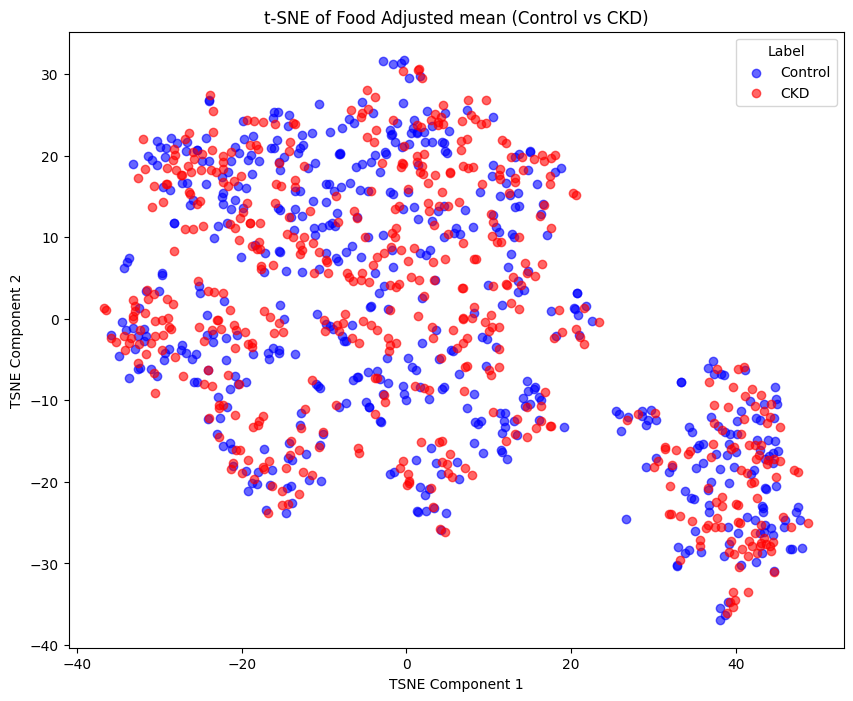

In [62]:
tsne_visualization(X_scaled_shap, y_food_mean, "Adjusted mean", seed)

In [63]:
hiddens = [
    # (64, 64), (64, 32), (64, 16), (64, 8), (64, 4),
    #         (32, 32), (32, 16), (32, 8), (32, 4),
            (16, 16), (16, 8), (16, 4), (8, 8), (8, 4), (4, 4)]

for hidden1, hidden2 in hiddens:
    
    print(f"===== hidden1 : {hidden1}, hidden2 : {hidden2} =====")
    
    cross_validate(MLP, X_scaled_shap, y, hidden1, hidden2)
    print("=" * 30)

===== hidden1 : 16, hidden2 : 16 =====
Fold 1
Test set results ==> loss= 0.6605, recall= 0.6327, precision= 0.5849, accuracy= 0.6190, AUC= 0.6199
Fold 2
Test set results ==> loss= 0.6727, recall= 0.6923, precision= 0.6000, accuracy= 0.6190, AUC= 0.6197
Fold 3
Test set results ==> loss= 0.6840, recall= 0.6122, precision= 0.5357, accuracy= 0.5714, AUC= 0.5740
Fold 4
Test set results ==> loss= 0.7113, recall= 0.4118, precision= 0.5385, accuracy= 0.5429, AUC= 0.5392
Fold 5
Test set results ==> loss= 0.6795, recall= 0.6346, precision= 0.6111, accuracy= 0.6190, AUC= 0.6192
Fold 6
Test set results ==> loss= 0.6543, recall= 0.6744, precision= 0.5000, accuracy= 0.5905, AUC= 0.6033
Fold 7
Test set results ==> loss= 0.7226, recall= 0.7143, precision= 0.5634, accuracy= 0.5524, AUC= 0.5408
Fold 8
Test set results ==> loss= 0.6770, recall= 0.6885, precision= 0.5915, accuracy= 0.5429, AUC= 0.5147
Fold 9
Test set results ==> loss= 0.7175, recall= 0.6613, precision= 0.5857, accuracy= 0.5238, AUC= 0.493

In [64]:
hiddens = [
    # (64, 64), (32, 32), 
    (16, 16), (8, 8), (4, 4)]

for hidden1, hidden2 in hiddens:
    
    print(f"===== hidden1 : {hidden1}, hidden2 : {hidden2} =====")
    
    cross_validate(MLP_1layer, X_scaled_shap, y, hidden1, hidden2)
    print("=" * 30)

===== hidden1 : 16, hidden2 : 16 =====
Fold 1
Test set results ==> loss= 0.6618, recall= 0.6735, precision= 0.5690, accuracy= 0.6095, AUC= 0.6135
Fold 2
Test set results ==> loss= 0.6937, recall= 0.6731, precision= 0.6364, accuracy= 0.6476, AUC= 0.6479
Fold 3
Test set results ==> loss= 0.6766, recall= 0.6122, precision= 0.5556, accuracy= 0.5905, AUC= 0.5918
Fold 4
Test set results ==> loss= 0.7224, recall= 0.5490, precision= 0.5091, accuracy= 0.5238, AUC= 0.5245
Fold 5
Test set results ==> loss= 0.6630, recall= 0.6923, precision= 0.6429, accuracy= 0.6571, AUC= 0.6575
Fold 6
Test set results ==> loss= 0.6533, recall= 0.6977, precision= 0.5172, accuracy= 0.6095, AUC= 0.6230
Fold 7
Test set results ==> loss= 0.7295, recall= 0.5714, precision= 0.5614, accuracy= 0.5333, AUC= 0.5306
Fold 8
Test set results ==> loss= 0.6755, recall= 0.4590, precision= 0.6512, accuracy= 0.5429, AUC= 0.5591
Fold 9
Test set results ==> loss= 0.7019, recall= 0.6129, precision= 0.6441, accuracy= 0.5714, AUC= 0.562

### ML works

In [88]:
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch

from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, make_scorer, recall_score, precision_score, accuracy_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression 

from sklearn.model_selection import cross_validate, StratifiedKFold

import xgboost as xgb

import os
import shap

import warnings
from sklearn.exceptions import ConvergenceWarning
import pickle

# ConvergenceWarning 경고를 무시
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def print_cv_results_ML(results_all_seed):
    # 모델별로 시드들의 평균과 표준편차를 구하는 부분
    results_summary = {}

    # 각 시드에 저장된 모델별 결과에 접근
    for seed in results_all_seed:
        for model_name in results_all_seed[seed]:
            if model_name not in results_summary:
                results_summary[model_name] = {
                    'recall': [],
                    'precision': [],
                    'accuracy': [],
                    'auc': [],
                    'recall_std': [],
                    'precision_std': [],
                    'accuracy_std': [],
                    'auc_std': []
                }
            # 각 시드의 성능 값을 추가
            results_summary[model_name]['recall'].append(results_all_seed[seed][model_name]['recall'][0])
            results_summary[model_name]['precision'].append(results_all_seed[seed][model_name]['precision'][0])
            results_summary[model_name]['accuracy'].append(results_all_seed[seed][model_name]['accuracy'][0])
            results_summary[model_name]['auc'].append(results_all_seed[seed][model_name]['auc'][0])
            results_summary[model_name]['recall_std'].append(results_all_seed[seed][model_name]['recall_std'][0])
            results_summary[model_name]['precision_std'].append(results_all_seed[seed][model_name]['precision_std'][0])
            results_summary[model_name]['accuracy_std'].append(results_all_seed[seed][model_name]['accuracy_std'][0])
            results_summary[model_name]['auc_std'].append(results_all_seed[seed][model_name]['auc_std'][0])

    # 모델별로 평균과 표준편차 계산
    for model_name in results_summary:
        print(f"Model: {model_name}")
        
        recall_mean = np.mean(results_summary[model_name]['recall'])
        recall_std = np.mean(results_summary[model_name]['recall_std'])
        
        precision_mean = np.mean(results_summary[model_name]['precision'])
        precision_std = np.mean(results_summary[model_name]['precision_std'])
        
        accuracy_mean = np.mean(results_summary[model_name]['accuracy'])
        accuracy_std = np.mean(results_summary[model_name]['accuracy_std'])
        
        auc_mean = np.mean(results_summary[model_name]['auc'])
        auc_std = np.mean(results_summary[model_name]['auc_std'])
        
        print(f"Recall Precision Accuracy AUC")
        print(f"{recall_mean:.4f}, {precision_mean:.4f}, {accuracy_mean:.4f}, {auc_mean:.4f}")
        print(f"{recall_std:.4f}, {precision_std:.4f}, {accuracy_std:.4f}, {auc_std:.4f}")    
        print("=" * 50)

In [109]:
# 42, 59, 63, 79, 101
seed = 42
set_seed(seed)

# data = pd.read_csv("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_food_mean_only.csv")
data = pd.read_csv("/home/user19/pnu_ckd/hexa_preprocessing_after95/0911_dl_models/data/0922_data/0922_food_adjusted_mean_only.csv")

In [110]:
data.columns

Index(['RID', 'onset_tight', 'F01_Mean_res', 'F02_Mean_res', 'F03_Mean_res',
       'F04_Mean_res', 'F05_Mean_res', 'F06_Mean_res', 'F07_Mean_res',
       'F08_Mean_res', 'F09_Mean_res', 'F10_Mean_res', 'F11_Mean_res',
       'F12_Mean_res', 'F13_Mean_res', 'F14_Mean_res', 'F15_Mean_res',
       'F16_Mean_res', 'F17_Mean_res', 'F18_Mean_res', 'F19_Mean_res',
       'F20_Mean_res', 'F21_Mean_res'],
      dtype='object')

In [111]:
# X_food_mean = data[data.columns[[0, 1, 2, 5, 3, 15, 13, 16, 7, 6, 8, 20]]]        # for food mean
X_food_mean = data[data.columns[[0, 1, 3, 2, 5, 13, 21, 6, 22, 8, 18, 17]]]          # for food adjusted mean

X_food_mean.columns

Index(['RID', 'onset_tight', 'F02_Mean_res', 'F01_Mean_res', 'F04_Mean_res',
       'F12_Mean_res', 'F20_Mean_res', 'F05_Mean_res', 'F21_Mean_res',
       'F07_Mean_res', 'F17_Mean_res', 'F16_Mean_res'],
      dtype='object')

In [101]:
""" Total Dataset ( Food + Basic ) """

results_all_seed = {}

n_split = 10
for seed in [42, 59, 63, 79, 101]:    
    datas = {"mean":(), "adjusted_mean":()}

    # datas['undersampling'] = undersampling(tight3_foodsum.drop(['CT1_eGFR'], axis=1), seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    datas['mean'] = undersampling(X_food_mean, seed=seed)        # eGFR 만을 빼면 성능이 줄어든다..
    # datas['adjusted_mean'] = undersampling(X_food_adjusted_mean, seed=seed)
    
    results_all_seed[seed] = {}  # 각 시드마다 딕셔너리 생성
    
    for data in ['mean']:
    # for data in ['adjusted_mean']:
        print(f"For {data} dataset!!!")
        # X_test, y_test = datas['test']
        X_train, y_train = datas[data]
        print(X_train.shape)
        
        wei_train_scaler = StandardScaler()
        X_train = wei_train_scaler.fit_transform(X_train)
        # X_test = wei_train_scaler.transform(X_test)
        print(f"{data} dataset loaded and scaled")
        print(f"X_train :: {X_train.shape}, y_train :: {y_train.shape}")
        
        scoring = {
        'recall': 'recall_macro',      # recall for each class, then averaged
        'precision': 'precision_macro',# precision for each class, then averaged
        'accuracy': 'accuracy',        # accuracy
        'auc': make_scorer(roc_auc_score, multi_class='ovr')  # AUC 계산 (이진 분류시)
        }
        
        models = (
            SVC(kernel='linear', random_state=seed, probability=True),
            RandomForestClassifier(random_state=seed, criterion='log_loss'),
            LogisticRegression(max_iter=1000, random_state=seed),
            GradientBoostingClassifier(random_state=seed, max_depth=3, learning_rate=0.02),
            # xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=seed)
        )
        
        for i, model in enumerate(models):
            model_name = model.__class__.__name__  # 모델 이름 저장
            print("=" * 30)
            print(f"Cross Validation for {model} in fold {n_split}, with seed {seed}")
            # Stratified K-Fold 교차 검증 (K=5)
            skf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=seed)
            results = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring, return_train_score=False)

            # 결과 출력
            print("각 폴드의 Recall:", results['test_recall'])
            print("각 폴드의 Precision:", results['test_precision'])
            print("각 폴드의 Accuracy:", results['test_accuracy'])
            print("각 폴드의 AUC:", results['test_auc'])

            # 결과 저장
            if model_name not in results_all_seed[seed]:
                results_all_seed[seed][model_name] = {
                    'recall': [], 
                    'precision': [], 
                    'accuracy': [], 
                    'auc': [],
                    'recall_std': [], 
                    'precision_std': [], 
                    'accuracy_std': [], 
                    'auc_std': []
                }
            results_all_seed[seed][model_name]['recall'].append(np.mean(results['test_recall']))
            results_all_seed[seed][model_name]['precision'].append(np.mean(results['test_precision']))
            results_all_seed[seed][model_name]['accuracy'].append(np.mean(results['test_accuracy']))
            results_all_seed[seed][model_name]['auc'].append(np.mean(results['test_auc']))
            results_all_seed[seed][model_name]['recall_std'].append(np.std(results['test_recall']))
            results_all_seed[seed][model_name]['precision_std'].append(np.std(results['test_precision']))
            results_all_seed[seed][model_name]['accuracy_std'].append(np.std(results['test_accuracy']))
            results_all_seed[seed][model_name]['auc_std'].append(np.std(results['test_auc']))
            
            
            # 평균값 계산
            print("평균 Recall, Precision, Accuracy, AUC:")
            print(f"{round(np.mean(results['test_recall']), 4)}, {round(np.mean(results['test_precision']),4)}, {round(np.mean(results['test_accuracy']), 4)}, {round(np.mean(results['test_auc']), 4)}")
            print("표준편차 Recall, Precision, Accuracy, AUC:")
            print(f"{round(np.std(results['test_recall']), 4)}, {round(np.std(results['test_precision']),4)}, {round(np.std(results['test_accuracy']), 4)}, {round(np.std(results['test_auc']), 4)}")
            print()
            
print_cv_results_ML(results_all_seed)

For mean dataset!!!
(1050, 11)
mean dataset loaded and scaled
X_train :: (1050, 11), y_train :: (1050,)
Cross Validation for SVC(kernel='linear', probability=True, random_state=42) in fold 10, with seed 42
각 폴드의 Recall: [0.52503628 0.54444848 0.51396952 0.5429971  0.57202467 0.6079463
 0.48566763 0.62790276 0.5892598  0.60976052]
각 폴드의 Precision: [0.52680653 0.55       0.51403061 0.54302832 0.57313928 0.62142857
 0.48566763 0.63055556 0.5955711  0.61      ]
각 폴드의 Accuracy: [0.52380952 0.54285714 0.51428571 0.54285714 0.57142857 0.60952381
 0.48571429 0.62857143 0.59047619 0.60952381]
각 폴드의 AUC: [0.52503628 0.54444848 0.51396952 0.5429971  0.57202467 0.6079463
 0.48566763 0.62790276 0.5892598  0.60976052]
평균 Recall, Precision, Accuracy, AUC:
0.5619, 0.565, 0.5619, 0.5619
표준편차 Recall, Precision, Accuracy, AUC:
0.0444, 0.0464, 0.0449, 0.0444

Cross Validation for RandomForestClassifier(criterion='log_loss', random_state=42) in fold 10, with seed 42
각 폴드의 Recall: [0.61865022 0.71462264 0.6

In [103]:
from sklearn.model_selection import GridSearchCV

gb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    # 'min_samples_leaf': [10, 15, 20, 25, 30],
    # 'min_samples_split': [2, 3, 5, 10],
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],
}
gb = GradientBoostingClassifier(random_state=42)

gb_grid = GridSearchCV(gb, param_grid=gb_param_grid, scoring='accuracy')
gb_grid.fit(X_food_adjusted_mean_train, y_food_adjusted_mean_train)

GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],
                         'max_depth': [3, 5], 'n_estimators': [100, 200]},
             scoring='accuracy')

In [104]:
best_gbc = gb_grid.best_estimator_
pred = best_gbc.predict(X_food_adjusted_mean_test)
acc = accuracy_score(y_food_adjusted_mean_test, pred)

In [105]:
gb_grid.best_params_

{'learning_rate': 0.04, 'max_depth': 5, 'n_estimators': 100}

In [106]:
acc

0.75

In [107]:
for seed in [42, 59, 63, 79, 101]:
        X_train, y_train = undersampling(food_adjusted_mean, seed=seed)

        wei_train_scaler = StandardScaler()
        X_train = wei_train_scaler.fit_transform(X_train)

        scoring = {
                'recall': 'recall_macro',      # recall for each class, then averaged
                'precision': 'precision_macro',# precision for each class, then averaged
                'accuracy': 'accuracy',        # accuracy
                'auc': make_scorer(roc_auc_score, multi_class='ovr')  # AUC 계산 (이진 분류시)
                }

        model = GradientBoostingClassifier(random_state=seed, max_depth=5, learning_rate=0.04)
        # model = RandomForestClassifier(random_state=seed, max_depth=3)

        skf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=seed)
        results = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring, return_train_score=False)
        # 결과 출력
        print("각 폴드의 Recall:", results['test_recall'].mean())
        print("각 폴드의 Precision:", results['test_precision'].mean())
        print("각 폴드의 Accuracy:", results['test_accuracy'].mean())
        print("각 폴드의 AUC:", results['test_auc'].mean())
        print("===" * 10)

각 폴드의 Recall: 0.6791545718432512
각 폴드의 Precision: 0.6810283061718089
각 폴드의 Accuracy: 0.6790476190476191
각 폴드의 AUC: 0.6791545718432512
각 폴드의 Recall: 0.7039368650217707
각 폴드의 Precision: 0.7048649611914289
각 폴드의 Accuracy: 0.7038095238095238
각 폴드의 AUC: 0.7039368650217708
각 폴드의 Recall: 0.6780841799709724
각 폴드의 Precision: 0.6792764578724111
각 폴드의 Accuracy: 0.6780952380952381
각 폴드의 AUC: 0.6780841799709725
각 폴드의 Recall: 0.6931966618287373
각 폴드의 Precision: 0.6947980330551246
각 폴드의 Accuracy: 0.6933333333333334
각 폴드의 AUC: 0.6931966618287372
각 폴드의 Recall: 0.707710449927431
각 폴드의 Precision: 0.7095245488311057
각 폴드의 Accuracy: 0.7076190476190477
각 폴드의 AUC: 0.707710449927431


# Shap visualization

In [ ]:
X_train_np = X_train_scaled.values
X_train_torch = torch.from_numpy(X_train_np).to(device).float()

X_test_np = X_test_scaled.values
X_test_torch = torch.from_numpy(X_test_np).to(device).float()

# get CKD, CONTROL index
ckd_idx = np.where(y_test == 1)[0]
control_idx = np.where(y_test == 0)[0]
y_test_np = y_test.values


#### DeepExplainer를 만들 때 X_test_torch랑 model을 학습할 때 사용한 training data랑 스케일이 같아야 함.
## 여기에서만 스케일이 같으면 됨.
explainer_shap = shap.DeepExplainer(model, X_train_torch)
shap_values = explainer_shap.shap_values(X_test_torch, check_additivity=False) ## very very slow  3900 row -> 118m

In [ ]:
print(shap_values.shape)
print(explainer_shap.expected_value)

## Summary plot

In [ ]:
# 색깔이 의미하는 것은 특성 값의 크기이다.
# X축 (shap value)의 값이 크면 모델의 예측을 증가시킨다는 의미이다.
# 예를 들어, CT1_eGFR이 작은 샘플(파란색)에 대해서 shap value가 크고, CT1_eGFR이 큰 샘플(빨간색)에 대해서 shap value가 작은 걸 보면
# eGFR이 작으면 모델의 예측값을 키우고, eGFR이 크면 모델의 예측값을 작게 한다. => 모델의 예측은 키우면 CKD로 분류, 줄이면 Control로 분류.

plt.figure()
shap.summary_plot(shap_values, X_test.values, feature_names=X_train.columns.tolist(),       # X_test 자리에 (ndarray)를 넣어야 색깔이 나옴.
                  cmap='bwr', show=False)
plt.title("Summary plot for basic & food adjusted mean")
plt.show()

In [ ]:
total_train = pd.merge(X_train, pd.DataFrame(y_train), left_index=True, right_index=True)

# Boxplot을 사용하여 "onset_tight" 별로 "CT1_eGFR" 분포 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='onset_tight', y='CT1_eGFR', data=total_train)

# 그래프 제목과 축 레이블 설정
plt.title('CT1_eGFR Distribution by onset_tight', fontsize=15)
plt.xlabel('onset_tight', fontsize=12)
plt.ylabel('CT1_eGFR', fontsize=12)

# 그래프 표시
plt.show()

## Decision plot

### decision plot by ((CKD or Control samples) & (CKD or Control outputs))

- ex) ckd sample이 모델이 ckd output을 내는 데에 얼마나 기여했는지를 의미하는 shap_value

In [ ]:
outputs.shape

In [ ]:
outputs_of_ckd, outputs_of_control = outputs[:52], outputs[52:]

### For CKD test sample

In [ ]:
plt.figure()
# 아래 그림에서 위부분의 결과값은 model output을 의미한다.
# 그림에서 직선의 기울기는 각 sample의 해당 column에 대한 shap_value 임.
shap.decision_plot(explainer_shap.expected_value,    # model output들의 평균. (여기서는 c=0이라서 control output들의 평균이다.)
                   shap_values[ckd_idx],    # shape : (5, 34)
                   X_test.values[ckd_idx],    # shape : (2, 34)
                   feature_names=X_train.columns.tolist(),
                   show=False
                  )
plt.title("Shap plot for CKD Samples")
plt.show()

In [ ]:
(outputs_of_ckd < 0.5)

In [ ]:
plt.figure()
# one ckd sample, CKD로 잘 예측한 sample.
n = 22
shap.decision_plot(explainer_shap.expected_value,
                   shap_values[n],    # shape : (5, 34)
                   X_test.values[n],    # shape : (2, 34)
                   feature_names=X_train.columns.tolist(),
                   show=False
                  )
plt.title(f"Shap plot for one CKD Sample")
plt.show()

In [ ]:
plt.figure()
# one ckd sample, CKD로 잘 예측한 sample.
n =11
shap.decision_plot(explainer_shap.expected_value,
                   shap_values[n],    # shape : (5, 34)
                   X_test.values[n],    # shape : (2, 34)
                   feature_names=X_train.columns.tolist(),
                   show=False
                  )
plt.title(f"Shap plot for one CKD Sample")
plt.show()

### For Control sample

For control output

In [ ]:
plt.figure()
# control sample이 ckd ( c=0 )쪽을 담당하는 output에 얼마나 기여를 했는지에 대한 shap_value를 시각화.
# 그림에서 직선의 기울기는 각 sample의 해당 column에 대한 shap_value 임.
shap.decision_plot(explainer_shap.expected_value,
                   shap_values[control_idx],    # shape : (5, 34)
                   X_test.values[control_idx],    # shape : (2, 34)
                   feature_names=X_train.columns.tolist(),
                   show=False)
plt.title("Shap plot for Control Samples")
plt.show()

In [ ]:
(outputs_of_control > 0.5)

In [ ]:
outputs_of_control[(outputs_of_control > 0.5)]

In [ ]:
# one control sample, Control로 잘 예측함.

plt.figure()
n = 66
shap.decision_plot(explainer_shap.expected_value,
                   shap_values[n],    # shape : (5, 34)
                   X_test.values[n],    # shape : (2, 34)
                   feature_names=X_train.columns.tolist(),
                   show=False)
plt.title("Shap plot for one Control Sample")
plt.show()

In [ ]:
# one control sample, for control output

plt.figure()
n = 75
shap.decision_plot(explainer_shap.expected_value,
                   shap_values[n],    # shape : (5, 34)
                   X_test.values[n],    # shape : (2, 34)
                   feature_names=X_train.columns.tolist(),
                   show=False)
plt.title("Shap plot for one Control Sample")
plt.show()

### Error samples 확인

In [ ]:
# 전체 틀린 갯수
(outputs_of_ckd < 0.5).sum().item() + (outputs_of_control > 0.5).sum().item()

In [ ]:
error_ckd = (outputs_of_ckd < 0.5).view(-1)
error_control = (outputs_of_control > 0.5).view(-1)
error_idx = torch.cat((error_ckd, error_control), dim=0)        # .view(-1, 1)

In [ ]:
total_test = pd.merge(X_test, pd.DataFrame(y_test), left_index=True, right_index=True)

In [ ]:
total_test

In [ ]:
error_testsamples = total_test[error_idx.numpy()]

In [ ]:
error_testsamples

In [ ]:
correct_testsamples = total_test[~error_idx.numpy()]

In [ ]:
correct_testsamples